In [ ]:
# Import the necessary libraries
import torch
import random
import warnings
import numpy as np
from utils import lab_to_rgb, show_prediction
import matplotlib.pyplot as plt
from train import train_cgan
warnings.filterwarnings("ignore")
from dataset import ColorizationDataset
from torch.utils.data import Subset, DataLoader
from models import UNetGenerator, PatchDiscriminator

In [7]:
# Set the random seeds for reproducibility
SEED = 27
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [8]:
# Initialize the data paths
DATA_ROOT = "/content/Data"                 # Set this to the root folder of your dataset (modify per user/environment)

l_path = f"{DATA_ROOT}/gray_scale.npy"
ab_paths = [
    f"{DATA_ROOT}/ab/ab1.npy",
    f"{DATA_ROOT}/ab/ab2.npy",
    f"{DATA_ROOT}/ab/ab3.npy",
]

# Load the L (lightness) channel as a memory-mapped array (read on demand from disk)
l_data = np.load(l_path, mmap_mode="r")     # Shape: (25000, 224, 224)

# Load and concatenate the ab (red–green, blue–yellow) channels as memory-mapped arrays
ab_data = [np.load(path, mmap_mode="r") for path in ab_paths]
ab_data = np.concatenate(ab_data, axis=0)   # Shape: (25000, 224, 224, 2)

In [9]:
# TODO Create the transforms for data augmentation on the training set; will require creating a simple one ourselves
train_transform = None
test_transform = None

# Create the datasets
full_train_ds = ColorizationDataset(l_data, ab_data, transform=train_transform)
full_test_ds  = ColorizationDataset(l_data, ab_data, transform=test_transform)

In [10]:
# Split the datasets into training (80%) and test (20%) sets
N = l_data.shape[0]
idxs = np.random.permutation(N)
train_size = int(0.8 * N)
train_idxs = idxs[:train_size]
test_idxs = idxs[train_size:]
train_dataset = Subset(full_train_ds, train_idxs)
test_dataset  = Subset(full_test_ds,  test_idxs)

In [11]:
# Create the dataloaders for each of the two datasets
BATCH_SIZE = 32
NUM_WORKERS = 2
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [12]:
# Determine which device to use (GPU if available, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [20]:
# Create the generator and discriminator models
generator = UNetGenerator()
discriminator = PatchDiscriminator()

# Train the models
train_cgan(generator, discriminator, train_loader, device=device, epochs=10)

Epoch 1/10 | G: 17.4117, D: 0.8993
Epoch 2/10 | G: 13.8044, D: 0.0999
Epoch 3/10 | G: 11.7078, D: 0.2465
Epoch 4/10 | G: 10.6792, D: 0.5399
Epoch 5/10 | G: 14.1254, D: 0.5455
Epoch 6/10 | G: 9.6829, D: 0.7124
Epoch 7/10 | G: 13.8649, D: 0.2746
Epoch 8/10 | G: 13.0345, D: 0.3605
Epoch 9/10 | G: 12.6971, D: 0.3138
Epoch 10/10 | G: 9.4698, D: 1.1093


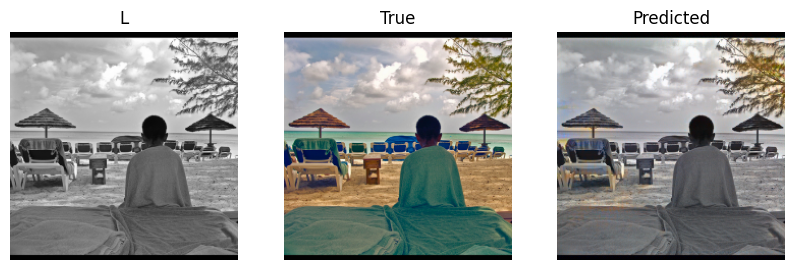

In [ ]:
show_prediction(generator, full_train_ds, idx=135)